In [1]:
!pip install fastai==0.7.0 --no-deps
!pip install torch==0.4.1 torchvision==0.2.1

     |████████████████████████████████| 122kB 2.7MB/s 
  Found existing installation: fastai 1.0.54
    Uninstalling fastai-1.0.54:
      Successfully uninstalled fastai-1.0.54
     |████████████████████████████████| 519.5MB 74kB/s 
     |████████████████████████████████| 61kB 30.2MB/s 
ERROR: allennlp 0.8.4 requires awscli>=1.11.91, which is not installed.
ERROR: allennlp 0.8.4 requires flaky, which is not installed.
ERROR: allennlp 0.8.4 requires responses>=0.7, which is not installed.
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: torchvision 0.3.0
    Uninstalling torchvision-0.3.0:
      Successfully uninstalled torchvision-0.3.0


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import numpy as np
import pandas as pd
import os

In [3]:
labels = pd.read_csv("../input/labels.csv")

In [4]:
## validation data
#val_idxs = get_cv_idxs(labels.shape[0])

In [5]:
PATH = "../input/"
TMP_PATH = "/tmp/tmp"
MODEL_PATH = "/tmp/model/"

In [6]:
arch=resnet101
sz=224
bs=48

In [7]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [8]:
data = ImageClassifierData.from_csv(path=PATH, folder="train", csv_fname=f"{PATH}labels.csv", tfms=tfms, suffix=".jpg", test_name="test",bs=bs,num_workers=4)

In [9]:
learn = ConvLearner.pretrained(arch, data, precompute=True, tmp_name=TMP_PATH, models_name=MODEL_PATH, ps=0.4)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /tmp/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:01<00:00, 113428855.35it/s]


  0%|          | 0/171 [00:00<?, ?it/s]

/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


100%|██████████| 216/216 [00:59<00:00,  5.08it/s]


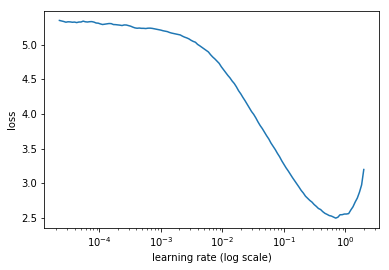

In [10]:
lrf = learn.lr_find()
learn.sched.plot()


In [11]:
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom = 1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', suffix='.jpg',tfms=tfms, bs=bs, num_workers=4)
    return data if sz > 300 else data.resize(sz, '/tmp')

In [12]:
##without augmentation
learn.fit(1e-1, 5)



epoch      trn_loss   val_loss   accuracy   
    0      0.835744   0.514161   0.859589  
    1      0.451133   0.483588   0.861057  
    2      0.352818   0.449918   0.881115  
    3      0.306318   0.462431   0.875245  
    4      0.221547   0.467102   0.876712  


[0.4671019158251365, 0.8767123516291788]

In [13]:
##with augmentation
learn.precompute=False
learn.fit(1e-1, 5, cycle_len=1)


epoch      trn_loss   val_loss   accuracy   
    0      0.290972   0.41678    0.885519  
    1      0.269364   0.415227   0.880137  
    2      0.279052   0.382802   0.8909    
    3      0.251303   0.401157   0.881605  
    4      0.221331   0.402171   0.889433  


[0.4021705919749116, 0.8894325076017361]

In [14]:
## increase size trick
learn.set_data(get_data(299,bs))

In [15]:
##and now resized
learn.fit(1e-1, 3, cycle_len=1)


epoch      trn_loss   val_loss   accuracy   
    0      0.250071   0.375443   0.895303  
    1      0.244552   0.379478   0.891879  
    2      0.222361   0.388757   0.890411  


[0.38875741769656275, 0.8904109787334434]

In [16]:
learn.fit(1e-1,3,cycle_len=1,cycle_mult=2)


epoch      trn_loss   val_loss   accuracy   
    0      0.230594   0.396887   0.891879  
    1      0.249009   0.431982   0.880626  
    2      0.185365   0.388288   0.891879  
    3      0.227101   0.397735   0.891389  
    4      0.240653   0.406752   0.889433  
    5      0.175768   0.386509   0.898239  
    6      0.140113   0.388525   0.89775   


[0.38852510497761333, 0.8977495305925433]

In [17]:
learn.fit(1e-1, 1, cycle_len=2)


epoch      trn_loss   val_loss   accuracy   
    0      0.196493   0.418823   0.886497  
    1      0.133267   0.398132   0.896282  


[0.39813218418865987, 0.896281821620441]

In [18]:
from sklearn.metrics import log_loss
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), log_loss(y, probs)

(0.9026418786692759, 0.3299173273096997)

In [19]:
log_preds_test, y_test = learn.TTA(is_test=True)
probs_test = np.mean(np.exp(log_preds_test), 0)
df = pd.DataFrame(probs_test)
df.columns = data.classes
df.insert(0, "id", [e[5:-4] for e in data.test_ds.fnames])
df.to_csv("submission.csv", index=False)